# **Model to Deblur and removal of Gaussian Noise from the CIFAR10 Dataset.**

by **Asif Khan Pattan**

**asifkhan.pattan@studio.unibo.it**

Results:

**Test loss: 0.0026421365328133106**

**Test accuracy: 0.862313985824585**




In [ ]:
#Importing the Required libraries 
    
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#Predefined function to generate noise+blurred images of the dataset

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)




Loading the dataset into **x_train(blurred image set for training), y_train(original image set for training), x_test(blurred image set for Validation/testing), y_test(original image set for Validation/testing)**

In [ ]:
(x_train, y_train), (x_test, y_test) = getDataset()


170508288/170498071 [==============================] - 2s 0us/step


Data Augmentation also prevents overfitting of the Model (but not used in this model)

In this model I used EarlyStopping to prevent model from Overfitting and also couple of Dropout Layers

In [ ]:
#DataAugmenatation 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


# Creation of the Model based on **AutoEncoder Architecture** 
Autoencoder Architecture is suitable to create output image similar to that of input image but with some processing/refinment. 
In this model, the pixel dimension of output image is same as that of the input image(32x32).

In [ ]:

#AutoEncoder model creation using Convolution Layers

model = Sequential()

#Encoder Layers with Relu Activation and 3x3 Kernals

model.add(layers.Conv2D(1024, (3,3), strides = 1,activation= 'relu', padding='same', input_shape = x_train.shape[1:]))
model.add(layers.Conv2D(256, (3,3), strides = 1, activation= 'relu'))
model.add(layers.Conv2D(128, (3,3), strides = 1, activation= 'relu'))
model.add(layers.Dropout(.2))                                                    # 20% Dropout layer to increase the Robustness of the Model
#latent

model.add(layers.Conv2D(32, (3,3), strides = 1,activation= 'relu'))

#Decoder Layers with Relu Activation and Transpose Convolution layers

model.add(layers.Conv2DTranspose(128, (3,3), strides = 1, activation= 'relu'))
model.add(layers.Conv2DTranspose(256, (3,3), strides = 1, activation= 'relu'))
model.add(layers.Conv2DTranspose(1024, (3,3), strides = 1, activation= 'relu'))
model.add(layers.Dropout(.2))                                                    # 20% Dropout layer to increase the Robustness of the Model
model.add(layers.Conv2DTranspose(3, (1, 1), strides = 1, activation='sigmoid', padding = 'same')) #final layer with same dimension as of Input layer to obtain the same dimension image


Compiling the model using **Mean Square Error** as Loss Function and **Adam** **Optimizer**

Using Callback to deal with OverFitting of the Model

In [ ]:
#Using EarlyStopping to stop Epochs when the model start to get Overfitting.

callback = EarlyStopping(monitor="val_accuracy",                   #based on Accuracy values 
    mode = "max",
    min_delta=0.001,
    patience=5,                                                    #the number of epochs without improvement after which training will be early stopped to stop overfitting
    restore_best_weights=True)


opt = keras.optimizers.Adam(learning_rate=0.0001)                  #Setting the learning rate of the model 
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])     # accuracy metric for visual understanding

Summary of the model with Number of Layers, Output shape of the layer and Parameters 

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 1024)      28672     
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 256)       2359552   
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       295040    
                                                                 
 dropout_2 (Dropout)         (None, 28, 28, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        36896     
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 128)      36992     
 ranspose)                                                       
                                                      

Fitting the Model with the Dataset

In [ ]:
history=model.fit(x_train, y_train,
                epochs=50,                           # maximum of 50 Epochs as we are using EarlyStopping to stop the Epoch while it starts to overfit the model
                batch_size=8,                       # Setting the Batch Size based on observations of the results obtained during model creation
                 shuffle=True,
                validation_data=(x_test, y_test), callbacks = [callback])    #Validation data set with Testing data

Epoch 1/50
6250/6250 [==============================] - 310s 49ms/step - loss: 0.0052 - accuracy: 0.7946 - val_loss: 0.0035 - val_accuracy: 0.8230
Epoch 2/50
6250/6250 [==============================] - 307s 49ms/step - loss: 0.0034 - accuracy: 0.8300 - val_loss: 0.0032 - val_accuracy: 0.8449
Epoch 3/50
6250/6250 [==============================] - 304s 49ms/step - loss: 0.0032 - accuracy: 0.8375 - val_loss: 0.0030 - val_accuracy: 0.8503
Epoch 4/50
6250/6250 [==============================] - 303s 48ms/step - loss: 0.0030 - accuracy: 0.8413 - val_loss: 0.0029 - val_accuracy: 0.8579
Epoch 5/50
6250/6250 [==============================] - 304s 49ms/step - loss: 0.0030 - accuracy: 0.8432 - val_loss: 0.0028 - val_accuracy: 0.8509
Epoch 6/50
6250/6250 [==============================] - 303s 48ms/step - loss: 0.0029 - accuracy: 0.8448 - val_loss: 0.0028 - val_accuracy: 0.8465
Epoch 7/50
6250/6250 [==============================] - 304s 49ms/step - loss: 0.0028 - accuracy: 0.8459 - val_loss: 0

Predecting the model on test set

In [ ]:
pred = model.predict(x_test)   

Plotting the "original image"(unblurred) and "Unblurred image by the model"

Original image


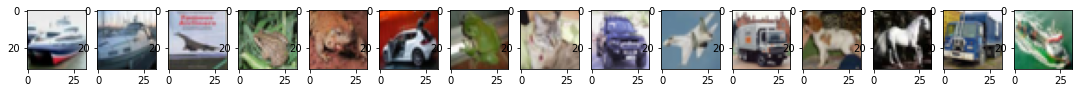

Reconstruction of Noisy Test Images


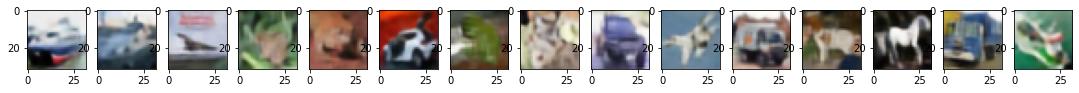

In [ ]:
#print(pred.shape)
#plotting the 15 samples of Original images  

plt.figure(figsize=(20, 4))
print("Original image")
for i in range(1,16,1):
    plt.subplot(1, 16, i+1)
    plt.imshow(y_test[i,:,:,:])
plt.show()  

#plotting the 15 samples of reconstructed deblurred images 

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(1,16,1):
    plt.subplot(1, 16, i+1)
    plt.imshow(pred[i,:,:,:])  
plt.show()

# **Evaluating the Model**

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0026421365328133106
Test accuracy: 0.862313985824585


Plotting the **Accuracy** of the Model with respect to the number of Epoch's

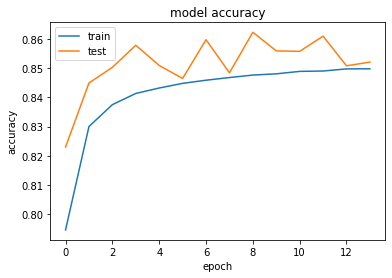

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

Plotting the **Loss** of the Model with respect to the number of Epoch's

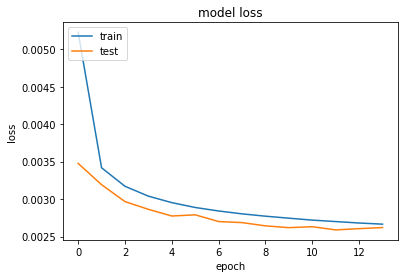

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Saving the Model and The Weights

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model_v3.5.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("c:\weights_v3.5")